# #1: Import Packages

In [1]:
# General 
import sys, numpy as np, pandas as pd, math, matplotlib.pyplot as plt, datetime, copy, os, re, random

# Pytorch, pytorch Geometric
import torch, torch_geometric
from torch_geometric.data import HeteroData

# Sklearn
import sklearn

sys.path.insert(1, '/home/ec2-user/SageMaker/repos/fredriks-thesis/python')
import helper_functions, graph_preprocessing, nn_models, hetero_models, graphSage_models, div_models, logistic_models, han_models

# #2: Settings

In [2]:
model_file_path = "/home/ec2-user/SageMaker/repos/fredriks-thesis/notebooks/09_model_performance_script/models/"

my_model_name = "97_ind_logistic_02_features"    

# 01_ind_logistic / 02_ind_logistic_features / 03_ind_logistic2layer_features 

# 04_ind_graphSage1Layer / 05_ind_graphSage2Layer / 06_ind_graphSage3Layer / 07_ind_graphSage3Layer_features

# 08_ind_NNConv1Layer / 09_ind_NNConv2Layer / 10_ind_NNConv3Layer / 11_ind_NNConv3Layer_features     

# 12_ind_NNConv1Layer_concatmsg / 13_ind_NNConv2Layer_concatmsg / 14_ind_NNConv1Layer_concatmsg_features

settings = {
      'dataset': 1e4
    , 'dataset_version': 'heterograph_externalnodes' 
    
    , 'python_file': 'logistic_models'    # logistic_models / graphSage_models / nn_models / han_models
    , 'model': 'logistic_02'        
                                                # logistic_models:  logistic_01 / logistic_02 / 
                                                # graphSage_models: SAGEConv1Layer / SAGEConv2Layer / SAGEConv3Layer / SAGEConv4Layer 
                                                # nn_models"        NNConv1Layer / NNConv2Layer / NNConv3Layer / NNConv4Layer 
                                                #                   / NNConv1Layer_concatmsg / NNConv2Layer_concatmsg / NNConv3Layer_concatmsg / NNConv4Layer_concatmsg
    
    , 'test_fraction': 0.3
    , 'seed': 0
    , 'train_who': 'ind'
    , 'remove_num_txns': False
    , 'learning_rate': 0.01
    , 'weight_decay': 1e-6
    , 'ca_num_batches': 0
    , 'max_epochs': 20000
    , 'n_batch_train': 1
    , 'check_progress_frequency': 100
    , 'lives': 5
    , 'n_folds': 5
    , 'delete_existing_models': False
    # Node features
    , 'degree_features'     : True
    , 'centrality_features' : True
    , 'deepwalk_features'   : True
    , 'metapath_features_1' : True
    , 'metapath_features_2' : True
    , 'metapath_features_3' : True
}

In [3]:
# Check if model directory exists
exists_str = '[ -d "{0}" ] && echo "Directory/file {0} exists."'.format(model_file_path+my_model_name)
exists = os.system(exists_str)

# If it exists, and delete_existing = True, we delete existing repo
if exists == 0 and settings['delete_existing_models']: os.system("rm -rf {}".format(model_file_path+my_model_name));


if exists != 0 or settings['delete_existing_models']: 
    # Create model directory
    os.mkdir(model_file_path + my_model_name);

    # Write train settings to text-file
    with open(model_file_path + my_model_name + '/train_settings.txt', 'w') as f: f.write(str(settings).replace(', ', '\n \t,')) #f.write(str(settings).replace(', ', '\n').replace('{','').replace('}','').replace("'", ""))

# #3: Load Dataset and Data Preprocessing

In [4]:
filepath = '/home/ec2-user/SageMaker/s3/exploration-876679093433-ew1-initiative-pop-amlanalysis/data/fredriks-thesis/heterographs_01/'

filename = settings['dataset_version'] + "_{:.0f}.pt".format(settings['dataset'])

data = torch.load(filepath+filename)

# Removing the attribute globalRiskScore
data['ind'].x = torch.cat((data['ind'].x[:,0:4], data['ind'].x[:,5:data['ind'].x.shape[1]]), 1)
data['org'].x = torch.cat((data['org'].x[:,0:3], data['org'].x[:,4:data['ind'].x.shape[1]]), 1)
#data['ind'].attr_names.remove('globalRiskScore')
#data['org'].attr_names.remove('globalRiskScore')

torch.manual_seed(settings['seed']) # Setting torch random state seed

# Create num_features variables
data['ind'].num_features = data['ind'].x.shape[1]
data['org'].num_features = data['org'].x.shape[1]
data['ext'].num_features = data['ext'].x.shape[1]

# Create train-and-test-sets
data['ind'].test_mask = graph_preprocessing.create_test_mask(data['ind'].y, settings['test_fraction'])
data['ind'].train_mask = ~data['ind'].test_mask
data['org'].test_mask = graph_preprocessing.create_test_mask(data['org'].y, settings['test_fraction'])
data['org'].train_mask = ~data['org'].test_mask

# Create cv-mask
data['ind'].cv_mask = graph_preprocessing.create_cv_mask(data['ind'].train_mask, settings['n_folds'])
data['org'].cv_mask = graph_preprocessing.create_cv_mask(data['org'].train_mask, settings['n_folds'])

# Add degree_features
if settings['degree_features']:
    my_filename = "degfeatures_ind_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ind'].x = torch.cat((data['ind'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "degfeatures_org_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['org'].x = torch.cat((data['org'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "degfeatures_ext_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ext'].x = torch.cat((data['ext'].x.detach(), my_import.detach()), dim = 1)
    
    
# Add centrality features
if settings['centrality_features']:
    my_filename = "centralities_ind_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ind'].x = torch.cat((data['ind'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "centralities_org_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['org'].x = torch.cat((data['org'].x.detach(), my_import.detach()), dim = 1)
    
# Add deepwalk features
if settings['deepwalk_features']:
    my_filename = "deepwalk_features_ind_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ind'].x = torch.cat((data['ind'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "deepwalk_features_org_{:.0f}.pt".format(settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['org'].x = torch.cat((data['org'].x.detach(), my_import.detach()), dim = 1)

# Add metapath features
if settings['metapath_features_1']: 
    my_filename = "metapath_features_ind_{}_{:.0f}.pt".format(1,settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ind'].x = torch.cat((data['ind'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "metapath_features_org_{}_{:.0f}.pt".format(1,settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['org'].x = torch.cat((data['org'].x.detach(), my_import.detach()), dim = 1)
    
if settings['metapath_features_2']:
    my_filename = "metapath_features_ind_{}_{:.0f}.pt".format(2,settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ind'].x = torch.cat((data['ind'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "metapath_features_org_{}_{:.0f}.pt".format(2,settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['org'].x = torch.cat((data['org'].x.detach(), my_import.detach()), dim = 1)

if settings['metapath_features_3']: 
    my_filename = "metapath_features_ind_{}_{:.0f}.pt".format(3,settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['ind'].x = torch.cat((data['ind'].x.detach(), my_import.detach()), dim = 1)
    
    my_filename = "metapath_features_org_{}_{:.0f}.pt".format(3,settings['dataset'])
    my_import = torch.load(filepath+my_filename)
    data['org'].x = torch.cat((data['org'].x.detach(), my_import.detach()), dim = 1)

# Reversing all edges 
data = graph_preprocessing.reverse_edges(data)
# Applying log to node feature transaction amounts and edge feature transaction amounts: 
data = graph_preprocessing.apply_log_to_txns(data)
# Normalizing node features
data = graph_preprocessing.normalize_node_features(data)
# Scaling edge_attributes to be in range [0.01,1]
data = graph_preprocessing.scaling_edge_attr(data)

# Removing the edge-feature num_txns so that the graph has only one edge feature (sum_txns)
if settings['remove_num_txns']==True: data = graph_preprocessing.remove_num_txns(data)

# Adding dummy-features for role-edges; ones for all edges
data[('ind', 'role', 'org')].edge_attr = torch.ones([data[('ind', 'role', 'org')].edge_index.shape[1],1], dtype = torch.float32)
data[('org', 'rev_role', 'ind')].edge_attr = torch.ones([data[('org', 'rev_role', 'ind')].edge_index.shape[1],1], dtype = torch.float32)

# Define device and transfer data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# #4: Define training-function

In [5]:
def train_batch(model, optimizer, loss_fun, batch, batch_size, train_who):
    optimizer.zero_grad()
    pred_ind_train, pred_org_train = model.forward(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
    pred = pred_ind_train[:batch_size]
    labels = batch['ind'].y[:batch_size]
    loss = loss_fun(pred, labels)
    loss.backward()
    optimizer.step()
    return float(loss), pred, labels

# #5: FOLDS

In [6]:
start_time_total = helper_functions.stopwatch()

train_hist_list = []
best_model_list = []

for fold in range(1, settings['n_folds']+1):
    print("!!!STARTING FOLD NUMBER: {} !!!".format(fold))    
    
    ################################################################################################
    #1: Create a copy of data for this fold, and create the correct train/test-masks
    ################################################################################################
    data_fold = copy.deepcopy(data)
    data_fold['ind'].test_mask = (data_fold['ind'].cv_mask==fold)
    data_fold['ind'].train_mask = (data_fold['ind'].cv_mask != 0) & (data_fold['ind'].cv_mask != fold)


    ################################################################################################
    # 2: Remove uneccecary parts of the data for training
    ################################################################################################
    n_layers = int(re.sub('\D', '', settings['model']))
    batch_size = math.ceil(data_fold['ind'].train_mask[data_fold['ind'].train_mask].shape[0]/(settings['ca_num_batches']+1))
    kwargs = {'num_workers': 8, 'persistent_workers': False}
    train_loader = torch_geometric.loader.NeighborLoader(
        data = data_fold,
        num_neighbors= [-1]*n_layers, # 1- means: For all nodes in the batch, we fetch all neighbors. 1 means: We create the subgraph by one iteration (we do not expand the graph beyond the neighbors of the nodes in the batch)
        input_nodes= ('ind', data_fold['ind'].train_mask),
        shuffle = True,
        batch_size = batch_size,
        **kwargs)

    for batch in iter(train_loader): data_train = batch.to(device)
    #data_train = copy.deepcopy(data_fold)
    #data_train.to(device)
    
    ################################################################################################
    #3: Create Objects for Model, Loss Function and Optimizer
    ################################################################################################        
    if settings['python_file']== 'han_models':
        model = getattr(eval(settings['python_file'] ), settings['model'])(
            num_features_ind = data['ind'].num_features
            , num_features_org = data['org'].num_features
            , num_features_ext = data['ext'].num_features
            , num_features_txn_edge = data[('ind', 'txn', 'ind')].edge_attr.shape[1]
            , metadata = data.metadata()
        ).to(device);
    else:
        model = getattr(eval(settings['python_file'] ), settings['model'])(
            num_features_ind = data['ind'].num_features
            , num_features_org = data['org'].num_features
            , num_features_ext = data['ext'].num_features
            , num_features_txn_edge = data[('ind', 'txn', 'ind')].edge_attr.shape[1]
        ).to(device);
    
    loss_fun = torch.nn.BCELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=settings['learning_rate'], weight_decay=settings['weight_decay']) 
    
    
    ################################################################################################
    #4: Checks if we should create new fold for this model, or load an old one
    ################################################################################################
    if not settings['delete_existing_models'] and os.path.isfile(model_file_path + my_model_name + "/model_fold_{}".format(fold)):         
        train_hist_list.append(pd.read_csv(model_file_path + my_model_name + "/train_hist_fold_{}.csv".format(fold), index_col= 0)); # Read train hist lost        
        # Read model file
        model.load_state_dict(torch.load(model_file_path + my_model_name + "/model_fold_{}".format(fold)))
        model.eval()
        model.cpu()
        best_model_list.append(model)
        continue
    
    ################################################################################################
    #5: !Training!
    ################################################################################################
    start_time = helper_functions.stopwatch()

    max_epochs = settings['max_epochs']
    n_batch_train = settings['n_batch_train']
    check_progress_frequency = settings['check_progress_frequency']
    lives = settings['lives']
    progress_idxs = list(range(0,max_epochs,check_progress_frequency))
    progress_idxs.append(max_epochs)
    train_hist = pd.DataFrame( columns = ['auc_ind_train','auc_ind_test', 'pr_auc_ind_train', 'pr_auc_ind_test', 'loss_ind_train', 'loss_ind_test'])

    model.train() # Initialize training
    for epoch in range(max_epochs):
        model.to(device)
        for i in range(n_batch_train): train_batch(model, optimizer, loss_fun, data_train, batch_size = data_train['ind'].batch_size, train_who = 'ind')       
        
        ################################################################################################
        ## Tracking Progress ##
        ################################################################################################
        if epoch%check_progress_frequency == 0 or epoch==max_epochs-1:
            # 1: Move data_train from GPU to CPU, 2: Move data_fold from CPU to GPU, 3: Predict on data_fold, 4: Move data_fold back to CPU, 5: Move data_train back to GPU
            data_train = data_train.cpu()
            data_fold = data_fold.to(device)
            pred_ind, pred_org = model.forward(data_fold.x_dict, data_fold.edge_index_dict, data_fold.edge_attr_dict)
            data_fold = data_fold.cpu()
            data_train = data_train.to(device)
            
            pred_ind = pred_ind.cpu()
            pred_org = pred_org.cpu()
            
            pred_ind = torch.tensor([x+(random.random()*1e-10) for x in pred_ind.detach().numpy()], dtype = torch.float32)
            pred_org = torch.tensor([x+(random.random()*1e-10) for x in pred_org.detach().numpy()], dtype = torch.float32)
            
            train_hist.loc[epoch] = pd.Series({  
                'auc_ind_train': sklearn.metrics.roc_auc_score(data_fold['ind'].y[data_fold['ind'].train_mask].detach().numpy(), pred_ind[data_fold['ind'].train_mask].detach().numpy())
              , 'auc_ind_test': sklearn.metrics.roc_auc_score(data_fold['ind'].y[data_fold['ind'].test_mask].detach().numpy(), pred_ind[data_fold['ind'].test_mask].detach().numpy())
              , 'pr_auc_ind_train': helper_functions.pr_auc_score(data_fold['ind'].y[data_fold['ind'].train_mask].detach().numpy(), pred_ind[data_fold['ind'].train_mask].detach().numpy())
              , 'pr_auc_ind_test': helper_functions.pr_auc_score(data_fold['ind'].y[data_fold['ind'].test_mask].detach().numpy(), pred_ind[data_fold['ind'].test_mask].detach().numpy())
              , 'loss_ind_train': loss_fun( pred_ind[data_fold['ind'].train_mask], data_fold['ind'].y[data_fold['ind'].train_mask]).item()
              , 'loss_ind_test': loss_fun( pred_ind[data_fold['ind'].test_mask], data_fold['ind'].y[data_fold['ind'].test_mask]).item() 
             })
            
            pred_ind = None; pred_org = None # Deleting these frees up GPU memory (for some unknown reason)
            
            # Save the best model so far
            if train_hist.pr_auc_ind_test.loc[epoch] >= max(train_hist.pr_auc_ind_test): best_model = copy.deepcopy(model)
            # Writing progress 
            tms = divmod((datetime.datetime.now() - start_time).days * 86400 + (datetime.datetime.now() - start_time).seconds, 60)            
            my_string = "Epoch:{}, Current Time: {}, Time Elapsed: {} min {} sek".format(epoch, datetime.datetime.now().strftime("%H:%M:%S"), tms[0], tms[1])
            my_string += ", auc_ind_train: {:.4f}, pr_auc_ind_train: {:.4f}, loss_ind_train: {:.4f} auc_ind_test {:.4f}, pr_auc_ind_test: {:.4f}, loss_ind_test: {:.4f}".format(
                              train_hist.loc[epoch]['auc_ind_train'], train_hist.loc[epoch]['pr_auc_ind_train'], train_hist.loc[epoch]['loss_ind_train']
                            , train_hist.loc[epoch]['auc_ind_test'], train_hist.loc[epoch]['pr_auc_ind_test'], train_hist.loc[epoch]['loss_ind_test'])
            # Early stopping
            if epoch in range(max_epochs-1):
                ind_decreasing = train_hist.auc_ind_test.loc[epoch] < max(train_hist.auc_ind_test) and train_hist.pr_auc_ind_test.loc[epoch] < max(train_hist.pr_auc_ind_test) and train_hist.loss_ind_test.loc[epoch] != min(train_hist.loss_ind_test)
                if  epoch > 1 and (    train_hist.pr_auc_ind_test.loc[epoch] < train_hist.pr_auc_ind_test[epoch-check_progress_frequency]
                                    or train_hist.loss_ind_train.loc[epoch] > train_hist.loss_ind_train[epoch-check_progress_frequency]): 
                        lives-=1; my_string+=". Lost a life! Remaining lives: {}".format(lives);
                elif lives < settings['lives']:                                              lives+=1; my_string+=". Gained a life! Remaining lives: {}".format(lives);
            print(my_string)
            if lives==0 or epoch==max_epochs-1: 
                print('!Stopping! Performance decreasing!'); 
                train_hist_list.append(train_hist); 
                best_model_list.append(best_model); 
                torch.save(best_model.state_dict(), model_file_path + my_model_name + "/model_fold_{}".format(fold)) # Save best model to file
                train_hist.to_csv(model_file_path + my_model_name + "/train_hist_fold_{}.csv".format(fold)) # Save train_hist
                break;
        ################################################################################################
            
    model = best_model
    helper_functions.stopwatch(start_time)
    ################################################################################################
    
helper_functions.stopwatch(start_time_total)
helper_functions.sound_alert()

!!!STARTING FOLD NUMBER: 1 !!!
Epoch:0, Current Time: 13:34:21, Time Elapsed: 0 min 7 sek, auc_ind_train: 0.7358, pr_auc_ind_train: 0.0435, loss_ind_train: 0.5066 auc_ind_test 0.7294, pr_auc_ind_test: 0.0419, loss_ind_test: 0.5066
Epoch:100, Current Time: 13:34:30, Time Elapsed: 0 min 16 sek, auc_ind_train: 0.8429, pr_auc_ind_train: 0.1133, loss_ind_train: 0.0340 auc_ind_test 0.8328, pr_auc_ind_test: 0.1050, loss_ind_test: 0.0340
Epoch:200, Current Time: 13:34:39, Time Elapsed: 0 min 24 sek, auc_ind_train: 0.8497, pr_auc_ind_train: 0.1252, loss_ind_train: 0.0334 auc_ind_test 0.8346, pr_auc_ind_test: 0.1082, loss_ind_test: 0.0337
Epoch:300, Current Time: 13:34:48, Time Elapsed: 0 min 33 sek, auc_ind_train: 0.8547, pr_auc_ind_train: 0.1331, loss_ind_train: 0.0331 auc_ind_test 0.8348, pr_auc_ind_test: 0.1073, loss_ind_test: 0.0337. Lost a life! Remaining lives: 4
Epoch:400, Current Time: 13:34:56, Time Elapsed: 0 min 42 sek, auc_ind_train: 0.8582, pr_auc_ind_train: 0.1381, loss_ind_train:

# #6: CV-Results

### Plotting Training Results 

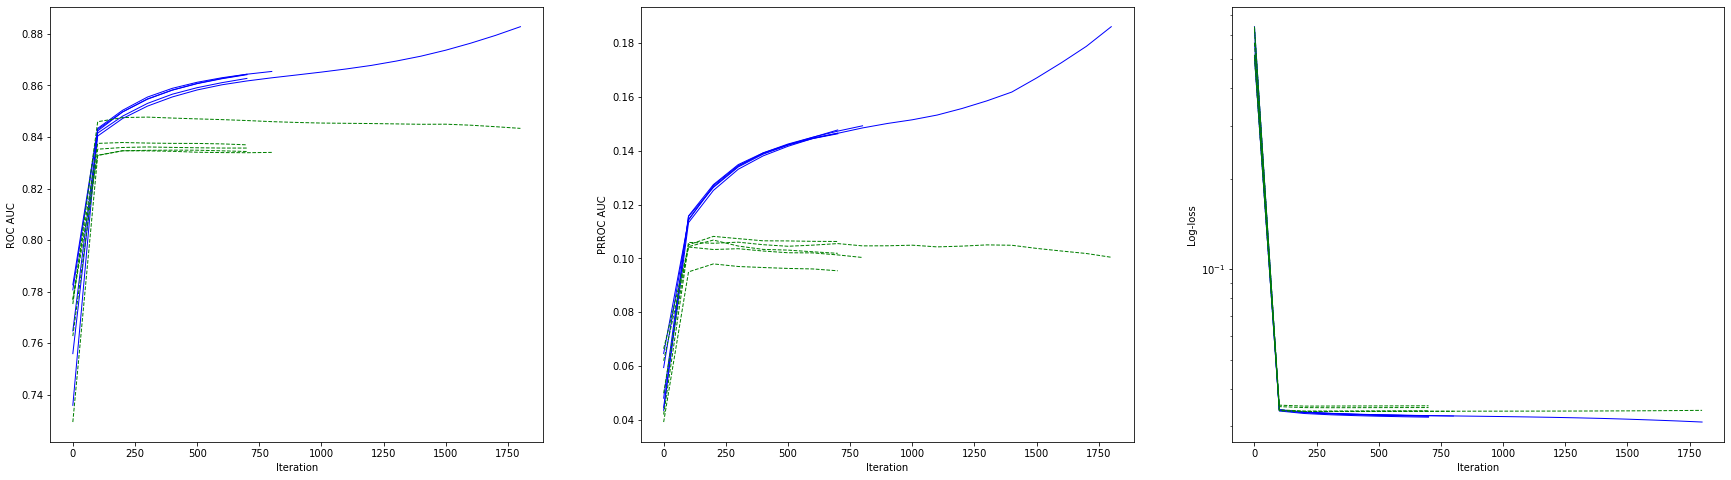

In [7]:
lw = 1

plt.figure(figsize = (30,8))
ax = plt.subplot(1, 3, 1)
for fold in range(0,settings['n_folds']): ax.plot(train_hist_list[fold]['auc_ind_train'], label = 'Train - Fold '+ str(fold), linewidth = lw, color = 'blue')
for fold in range(0,settings['n_folds']): ax.plot(train_hist_list[fold]['auc_ind_test'],  label = 'Val - Fold '  + str(fold), linewidth = lw, linestyle='dashed', color = 'green')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
#ax.legend();

ax = plt.subplot(1, 3, 2)
for fold in range(0,settings['n_folds']): ax.plot(train_hist_list[fold]['pr_auc_ind_train'], label = 'Train - Fold '+ str(fold), linewidth = lw, color = 'blue')
for fold in range(0,settings['n_folds']): ax.plot(train_hist_list[fold]['pr_auc_ind_test'],  label = 'Val - Fold '  + str(fold), linewidth = lw, linestyle='dashed', color = 'green')
plt.xlabel('Iteration')
plt.ylabel('PRROC AUC')
#ax.legend();

ax = plt.subplot(1, 3, 3)
for fold in range(0,settings['n_folds']): ax.plot(train_hist_list[fold]['loss_ind_train'], label = 'Train - Fold '+ str(fold), linewidth = lw, color = 'blue')
for fold in range(0,settings['n_folds']): ax.plot(train_hist_list[fold]['loss_ind_test'],  label = 'Val - Fold '  + str(fold), linewidth = lw, linestyle='dashed', color = 'green')
plt.xlabel('Iteration')
plt.ylabel('Log-loss')
ax.set_yscale('log');
#ax.legend();

### Plotting AUCs of CV-results

In [8]:
plot_auc = False
if plot_auc: 
    plt.figure(figsize = (30,15))
    title_fontsize = 20
    label_fontsize = 15
    legend_fontsize = 15
    lw = 0.8
    ms = 0


    from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
    from matplotlib import pyplot

    for fold in range(1, settings['n_folds']+1): 
        ################################################################################################
        #1: Create a copy of data for this fold, and create the correct train/test-masks
        ################################################################################################
        data_fold = copy.deepcopy(data)
        data_fold = data_fold.to(device)
        data_fold['ind'].test_mask = (data_fold['ind'].cv_mask==fold)
        data_fold['ind'].train_mask = (data_fold['ind'].cv_mask != 0) & (data_fold['ind'].cv_mask != fold)
        data_fold = data_fold.to("cpu")
        model = best_model_list[fold-1].to("cpu")

        ################################################################################################
        #2: Get predictions and labels for train and test
        ################################################################################################
        pred_ind, pred_org = model.forward(data_fold.x_dict, data_fold.edge_index_dict, data_fold.edge_attr_dict)
        pred = pred_ind.detach().numpy() 
        y = data_fold['ind'].y.detach().numpy() 
        pred_train = pred[data_fold['ind'].train_mask]
        y_train = y[data_fold['ind'].train_mask]
        pred_test = pred[data_fold['ind'].test_mask]
        y_test = y[data_fold['ind'].test_mask]
        
        pred_test = np.array([x+(random.random()*1e-10) for x in pred_test])
        pred_train = np.array([x+(random.random()*1e-10) for x in pred_train])

        ################################################################################################
        #3: PLOT ROC-CURVE
        ################################################################################################
        # Train
        ax = plt.subplot(2, 2, 1)
        fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
        pyplot.plot(fpr_train, tpr_train, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (roc_auc_score(y_train, pred_train)))
        # Test
        ax = plt.subplot(2, 2, 2)
        fpr, tpr, _ = roc_curve(y_test, pred_test)
        pyplot.plot(fpr, tpr, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (roc_auc_score(y_test, pred_test)))

        ################################################################################################
        #4: PLOT PR-CURVE
        ################################################################################################
        # Train
        ax = plt.subplot(2, 2, 3)
        train_precision, train_recall, _  = precision_recall_curve(y_train, pred_train)
        pyplot.plot(train_recall, train_precision, linewidth = lw, marker='.', markersize = ms, label='AUC:%.3f' % (sklearn.metrics.auc(train_recall, train_precision)))
        # Test
        ax = plt.subplot(2, 2, 4)
        test_precision, test_recall, _  = precision_recall_curve(y_test, pred_test)
        pyplot.plot(test_recall, test_precision, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (sklearn.metrics.auc(test_recall, test_precision)))

    ax = plt.subplot(2, 2, 1)
    pyplot.plot([0,1],[0,1], linestyle='--', color = 'b', linewidth = lw)
    pyplot.xlabel('False Positive Rate', fontsize = label_fontsize)
    pyplot.ylabel('True Positive Rate', fontsize = label_fontsize)
    pyplot.title('ROC-CURVE TRAIN', fontsize = title_fontsize)
    pyplot.legend(fontsize = legend_fontsize)

    ax = plt.subplot(2, 2, 2)
    pyplot.plot([0,1],[0,1], linestyle='--', color = 'b', linewidth = lw)
    pyplot.xlabel('False Positive Rate', fontsize = label_fontsize)
    pyplot.ylabel('True Positive Rate', fontsize = label_fontsize)
    pyplot.title('ROC-CURVE TEST', fontsize = title_fontsize)
    pyplot.legend(fontsize = legend_fontsize)

    ax = plt.subplot(2, 2, 3)
    pyplot.xlabel('False Positive Rate', fontsize = label_fontsize)
    pyplot.ylabel('True Positive Rate', fontsize = label_fontsize)
    pyplot.title('PR-CURVE TRAIN', fontsize = title_fontsize)
    pyplot.legend(fontsize = legend_fontsize)

    ax = plt.subplot(2, 2, 4)
    pyplot.xlabel('False Positive Rate', fontsize = label_fontsize)
    pyplot.ylabel('True Positive Rate', fontsize = label_fontsize)
    pyplot.title('PR-CURVE TEST', fontsize = title_fontsize)
    pyplot.legend(fontsize = legend_fontsize)

    pyplot.show()

## BEST MODEL STATS

In [9]:
best_model_stats = pd.DataFrame( columns = ['auc_ind_train','auc_ind_test', 'pr_auc_ind_train', 'pr_auc_ind_test', 'loss_ind_train', 'loss_ind_test'])

for fold in range(0,settings['n_folds']):   
    yolo = train_hist_list[fold].loc[train_hist_list[fold].pr_auc_ind_test == max (train_hist_list[fold].pr_auc_ind_test)]
    best_model_stats = best_model_stats.append(yolo)
    
best_model_stats['n_iterations'] = best_model_stats.index
best_model_stats.agg(['mean','min', 'max', 'std'])

,auc_ind_train,auc_ind_test,pr_auc_ind_train,pr_auc_ind_test,loss_ind_train,loss_ind_test,n_iterations
mean,0.848575,0.837814,0.125605,0.104620,0.033394,0.034167,200.000000
min,0.843352,0.832910,0.114466,0.097929,0.033091,0.033597,100.000000
max,0.851983,0.847724,0.134856,0.108162,0.034034,0.035020,300.000000
std,0.003232,0.005828,0.007290,0.004004,0.000379,0.000621,70.710678


# #7: Apply models using the best model in each fold (We Don't use the test set to pick the model!!)

In [10]:
################################################################################################
#6: Predict on the full dataset on each model from each fold, and let the mean value be the final prediction
################################################################################################
import gc
pred_ind = torch.zeros(data['ind'].x.shape[0], dtype = torch.float32)
pred_org = torch.zeros(data['org'].x.shape[0], dtype = torch.float32)
data.cpu()
for fold in range(0,settings['n_folds']):  
    gc.collect()
    best_model_list[0].cpu()
    pred_ind_fold, pred_org_fold = best_model_list[0].forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    
    
    pred_ind_fold = torch.tensor([x+(random.random()*1e-10) for x in pred_ind_fold.detach().numpy()], dtype = torch.float32)
    pred_org_fold = torch.tensor([x+(random.random()*1e-10) for x in pred_org_fold.detach().numpy()], dtype = torch.float32)
    
    
    pred_ind = pred_ind + pred_ind_fold.detach()
    pred_org = pred_org + pred_org_fold.detach()
    del pred_ind_fold, pred_org_fold
    
pred_ind = pred_ind/(settings['n_folds'])
pred_org = pred_org/(settings['n_folds'])

<Figure size 2160x1080 with 0 Axes>

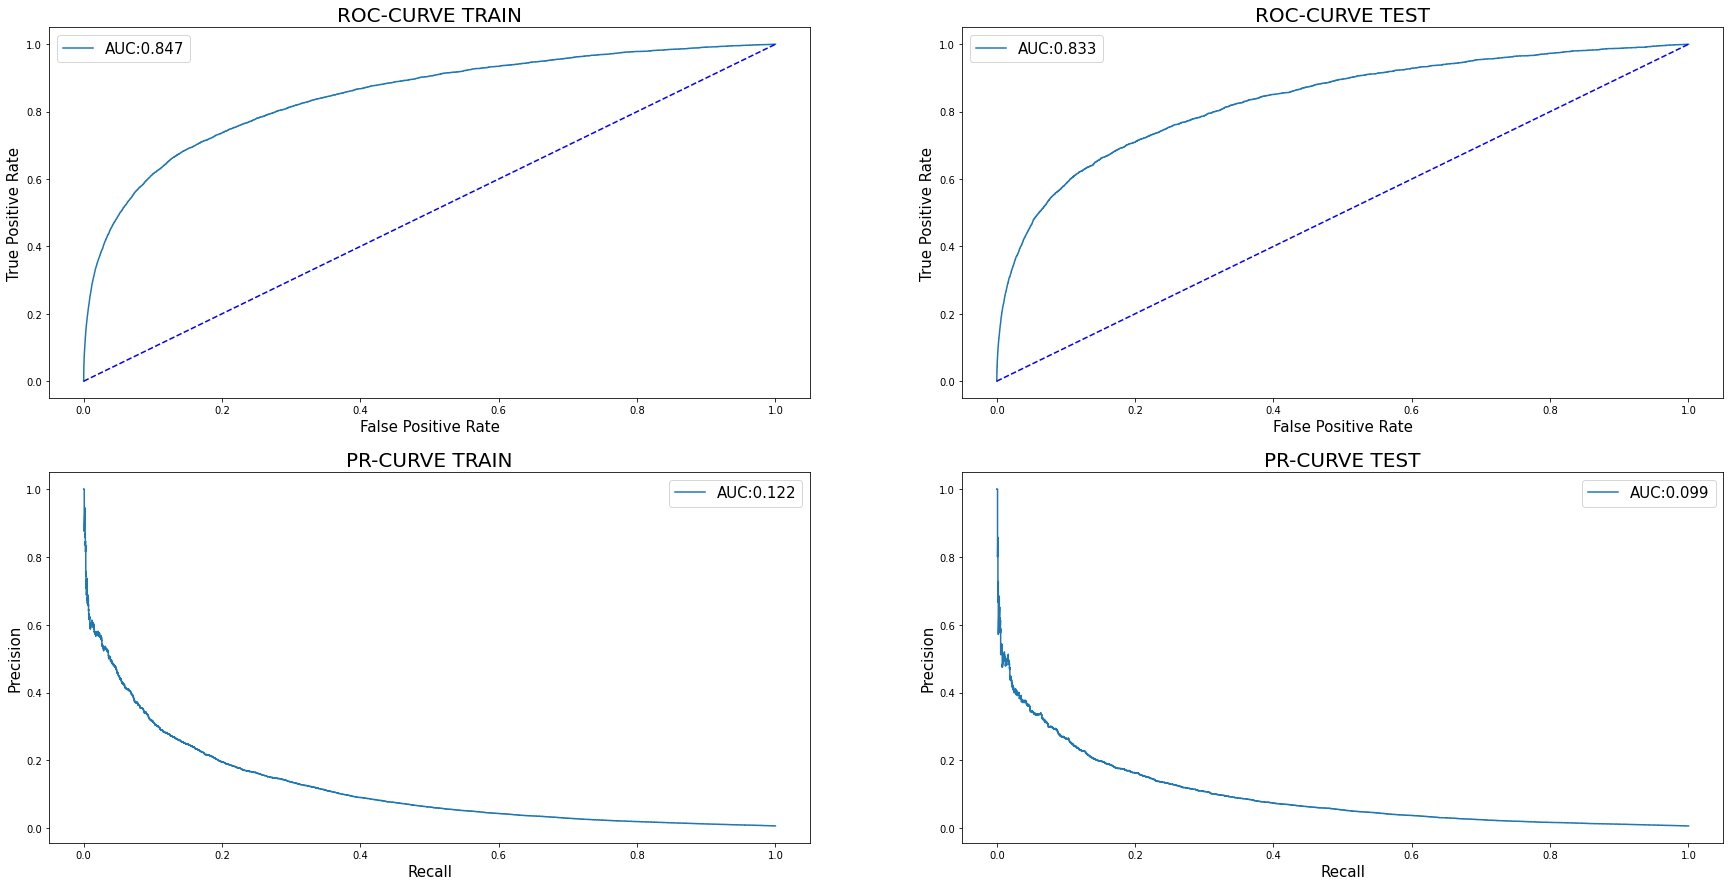

Done in: 0 min 3 sek


In [11]:
################################################################################################
#6: Plotting AUCs of final results
################################################################################################
start_time = helper_functions.stopwatch()

plt.figure(figsize = (30,15))
plt.figure(figsize = (30,15))
title_fontsize = 20
label_fontsize = 15
legend_fontsize = 15
lw = 1.5
ms = 0

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from matplotlib import pyplot

#1: Get data and model
model = model.to("cpu")
data = data.to("cpu")

#2: Get predictions and labels for train and test
#pred_ind, pred_ind = model.forward(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
pred = pred_ind.detach().numpy() 
y = data['ind'].y.detach().numpy() 
pred_train = pred[data['ind'].train_mask]
y_train = y[data['ind'].train_mask]
pred_test = pred[data['ind'].test_mask]
y_test = y[data['ind'].test_mask]

#3: PLOT ROC-CURVE
# Train
ax = plt.subplot(2, 2, 1)
fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
pyplot.plot(fpr_train, tpr_train, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (roc_auc_score(y_train, pred_train)))
# Test
ax = plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, pred_test)
pyplot.plot(fpr, tpr, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (roc_auc_score(y_test, pred_test)))

#4: PLOT PR-CURVE
# Train
ax = plt.subplot(2, 2, 3)
train_precision, train_recall, _  = precision_recall_curve(y_train, pred_train)
pyplot.plot(train_recall, train_precision, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (sklearn.metrics.auc(train_recall, train_precision)))
# Test
ax = plt.subplot(2, 2, 4)
test_precision, test_recall, _  = precision_recall_curve(y_test, pred_test)
pyplot.plot(test_recall, test_precision, marker='.', markersize = ms, linewidth = lw, label='AUC:%.3f' % (sklearn.metrics.auc(test_recall, test_precision)))
    
ax = plt.subplot(2, 2, 1)
pyplot.plot([0,1],[0,1], linestyle='--', color = 'b')
pyplot.xlabel('False Positive Rate', fontsize = label_fontsize)
pyplot.ylabel('True Positive Rate', fontsize = label_fontsize)
pyplot.title('ROC-CURVE TRAIN', fontsize = title_fontsize)
pyplot.legend(fontsize = legend_fontsize)

ax = plt.subplot(2, 2, 2)
pyplot.plot([0,1],[0,1], linestyle='--', color = 'b')
pyplot.xlabel('False Positive Rate', fontsize = label_fontsize)
pyplot.ylabel('True Positive Rate', fontsize = label_fontsize)
pyplot.title('ROC-CURVE TEST', fontsize = title_fontsize)
pyplot.legend(fontsize = legend_fontsize)

ax = plt.subplot(2, 2, 3)
pyplot.xlabel('Recall', fontsize = label_fontsize)
pyplot.ylabel('Precision', fontsize = label_fontsize)
pyplot.title('PR-CURVE TRAIN', fontsize = title_fontsize)
pyplot.legend(fontsize = legend_fontsize)

ax = plt.subplot(2, 2, 4)
pyplot.xlabel('Recall', fontsize = label_fontsize)
pyplot.ylabel('Precision', fontsize = label_fontsize)
pyplot.title('PR-CURVE TEST', fontsize = title_fontsize)
pyplot.legend(fontsize = legend_fontsize)
pyplot.show()


# printing key numbers for final model
# ?

helper_functions.stopwatch(start_time)
helper_functions.sound_alert()

# #8: Looking at top-scoring nodes

In [12]:
top_frac = 0.001
df = pd.DataFrame(
          np.concatenate((pred_test, y_test)).reshape((2,pred_test.shape[0])).T
        , columns = ['score','y']).sort_values(by = 'score', ascending = False)
lift_test =helper_functions.compute_lift(df, top_frac)
print("Test Set Organizations: Top score for {:.2%} ({} customers): Precision: {:.4f}, Recall: {:.4f}, lift: {:.2f}".format(top_frac, math.ceil(df.shape[0]*top_frac), lift_test[0], df.shape[0]*top_frac*lift_test[0]/df.loc[df.y==1].shape[0], lift_test[1]))

Test Set Organizations: Top score for 0.10% (510 customers): Precision: 0.3451, Recall: 0.0498, lift: 49.75


## Creating Precision-Recall-Lift Table

In [13]:
n_1 = df.loc[df.y==1].shape[0]
n_0 = df.loc[df.y==0].shape[0]

recalls = [0.001, 0.01, 0.05, 0.1, 0.5]
n_1_recalls = [math.ceil(x*n_1) for x in recalls]

l = len(recalls)
df = df.reset_index(drop = True)
df_1 = df.loc[df.y==1]

n_1_recalls_index = [int(df_1.iloc[[x-1]].index.values) for x in n_1_recalls]
precs = []
for i in range(l):
    precs.append(n_1_recalls[i]/(n_1_recalls_index[i]+1))
    
df_pr_rec = pd.DataFrame(np.concatenate(([x+1 for x in n_1_recalls_index],n_1_recalls,recalls,precs, [x/(n_1/(n_0+n_1)) for x in precs])).reshape(5,l), index = ["Predicting 1", "Actual 1","Recall", "Precision", "Lift"])

df_pr_rec

,0,1,2,3,4
Predicting 1,4.000000,70.000000,511.000000,1336.000000,32675.000000
Actual 1,4.000000,36.000000,177.000000,354.000000,1769.000000
Recall,0.001000,0.010000,0.050000,0.100000,0.500000
Precision,1.000000,0.514286,0.346380,0.264970,0.054139
Lift,144.173876,74.146565,49.938896,38.201761,7.805466


In [14]:
df_pr_rec = pd.DataFrame(np.concatenate(([x*100 for x in recalls],[x*100 for x in precs], [x/(n_1/(n_0+n_1)) for x in precs])).reshape(3,l), index = ["Recall (%)", "Precision (%)", "Lift"])
pd.set_option('display.precision', 2)
df_pr_rec

,0,1,2,3,4
Recall (%),0.10,1.00,5.00,10.0,50.00
Precision (%),100.00,51.43,34.64,26.5,5.41
Lift,144.17,74.15,49.94,38.2,7.81


In [15]:
PRAUC = sklearn.metrics.auc(test_recall, test_precision)
ROCAUC = roc_auc_score(y_test, pred_test)

print("PRAUC: {:.6f}".format(PRAUC))
print("ROCAUC: {:.6f}".format(ROCAUC))

PRAUC: 0.099287
ROCAUC: 0.832702


# TEST

In [16]:
data_fold['org'].test_mask = (data_fold['org'].cv_mask==fold)
data_fold['org'].train_mask = (data_fold['org'].cv_mask != 0) & (data_fold['org'].cv_mask != fold)

In [17]:


test_mask = data['org'].test_mask
train_mask = data['org'].train_mask
cv_mask = data['org'].cv_mask

print(test_mask.shape[0])
print(train_mask.shape[0])
print(cv_mask.shape[0])

print(test_mask.unique(return_counts = True))
print(train_mask.unique(return_counts = True))
print(cv_mask.unique(return_counts = True))

195764
195764
195764
(tensor([False,  True]), tensor([136588,  59176]))
(tensor([False,  True]), tensor([ 59176, 136588]))
(tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32), tensor([59176, 27318, 27318, 27318, 27317, 27317]))


In [18]:
(test_mask & ~train_mask).unique(return_counts = True)

(tensor([False,  True]), tensor([136588,  59176]))

In [19]:
(cv_mask==0 & train_mask).unique(return_counts = True)

(tensor([False,  True]), tensor([136588,  59176]))

In [20]:
M = torch.cat((train_mask[:,None],test_mask[:,None],cv_mask[:,None]), axis = -1)
np.unique(M, axis=0, return_counts = True)

(array([[0, 1, 0],
        [1, 0, 1],
        [1, 0, 2],
        [1, 0, 3],
        [1, 0, 4],
        [1, 0, 5]], dtype=int32),
 array([59176, 27318, 27318, 27318, 27317, 27317]))